*Random* forest classifier using scikit-learn


Import modules

In [24]:
# from sklearn import datasets, metrics
# from sklearn.ensemble import RandomForestClassifier

# import pandas as pd
# import numpy as np
# pd.set_option('display.max_columns', None)
# pd.options.mode.chained_assignment = None


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing,linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

Loading dataset


In [2]:
df = pd.read_json('dataset/complaints.json.zip', dtype=str)

In [3]:
df.head()

,date_received,product,sub_product,issue,sub_issue,complaint_what_happened,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response,timely,consumer_disputed,complaint_id
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,,,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,N/A,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,,Consent provided,Web,2019-11-01,Closed with explanation,Yes,N/A,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,N/A,3198225
3,2019-07-18,"Credit reporting, credit repair services, or o...",Credit repair services,Unexpected or other fees,,In XXXX I retained Freedom Debt Relief to help...,,FREEDOM FINANCIAL NETWORK,OH,440XX,,Consent provided,Web,2019-07-22,Closed with monetary relief,Yes,N/A,3310591
4,2019-08-08,Mortgage,Conventional home mortgage,Trouble during payment process,,,Company has responded to the consumer and the ...,"FLAGSTAR BANK, FSB",ID,83706,,N/A,Referral,2019-08-15,Closed with explanation,Yes,N/A,3342290


Select dataset columns

In [7]:
df['complaint_what_happened'].replace('', np.nan, inplace=True)
df.dropna(subset=['complaint_what_happened'], inplace=True)
df = df.head(4096)

In [8]:
df.shape

(4096, 18)

In [9]:
df.isnull().sum()

date_received                0
product                      0
sub_product                  0
issue                        0
sub_issue                    0
complaint_what_happened      0
company_public_response      0
company                      0
state                        0
zip_code                     0
tags                         0
consumer_consent_provided    0
submitted_via                0
date_sent_to_company         0
company_response             0
timely                       0
consumer_disputed            0
complaint_id                 0
dtype: int64

In [10]:
df = df[['company_response', 'complaint_what_happened','company_public_response']]

In [11]:
df.isnull().sum()

company_response           0
complaint_what_happened    0
company_public_response    0
dtype: int64

In [12]:
df['company_response'].value_counts()

Closed with explanation            3388
Closed with non-monetary relief     509
Closed with monetary relief         185
Untimely response                    12
Closed                                2
Name: company_response, dtype: int64

In [13]:
df['company_public_response'].value_counts()

                                                                                                                           2030
Company has responded to the consumer and the CFPB and chooses not to provide a public response                            1738
Company believes it acted appropriately as authorized by contract or law                                                    240
Company believes the complaint is the result of a misunderstanding                                                           23
Company believes complaint represents an opportunity for improvement to better serve consumers                               17
Company disputes the facts presented in the complaint                                                                        16
Company believes complaint is the result of an isolated error                                                                12
Company believes complaint caused principally by actions of third party outside the control or direction

In [15]:
actions={'Company has responded to the consumer and the CFPB and chooses not to provide a public response':'Dispute',
         'Company believes it acted appropriately as authorized by contract or law':'Dispute',
         'Company chooses not to provide a public response':'Dispute',
          'Company believes the complaint is the result of a misunderstanding':'Agrees',
         'Company disputes the facts presented in the complaint':'Dispute',
          'Company believes complaint is the result of an isolated error':'Agrees',
          'Company believes complaint caused principally by actions of third party outside the control or direction of the company':'Dispute',
          'Company believes complaint represents an opportunity for improvement to better serve consumers':'Agrees',
          "Company can't verify or dispute the facts in the complaint":'Less informative',
          "Company believes the complaint provided an opportunity to answer consumer's questions":'Agrees',
          'Company believes complaint relates to a discontinued policy or procedure':'Dispute',
         }

In [16]:
df['actions']=df['company_public_response'].map(actions)

In [17]:
df.head()

,company_response,complaint_what_happened,company_public_response,actions
1,Closed with explanation,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,Dispute
3,Closed with monetary relief,In XXXX I retained Freedom Debt Relief to help...,,NaN
5,Closed with explanation,Hello This complaint is against the three cred...,Company has responded to the consumer and the ...,Dispute
6,Closed with explanation,I am a victim of Identity Theft & currently ha...,Company has responded to the consumer and the ...,Dispute
7,Closed with explanation,I have a active XXXX XXXX credit card in good ...,Company has responded to the consumer and the ...,Dispute


In [18]:
df.dropna(subset=['actions'], inplace=True)
df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

,company_response,complaint_what_happened,company_public_response,actions
1,Closed with explanation,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,Dispute
5,Closed with explanation,Hello This complaint is against the three cred...,Company has responded to the consumer and the ...,Dispute
6,Closed with explanation,I am a victim of Identity Theft & currently ha...,Company has responded to the consumer and the ...,Dispute
7,Closed with explanation,I have a active XXXX XXXX credit card in good ...,Company has responded to the consumer and the ...,Dispute
9,Closed with non-monetary relief,Two accounts are still on my credit history af...,Company has responded to the consumer and the ...,Dispute
...,...,...,...,...
8281,Closed with non-monetary relief,I filed a dispute on XX/XX/XXXX for a charge o...,Company has responded to the consumer and the ...,Dispute
8286,Closed with explanation,"Problem with Citibank , N.A . \nIn XX/XX/2019 ...",Company has responded to the consumer and the ...,Dispute
8298,Closed with explanation,I don't recognize this credit inquiry nor did ...,Company has responded to the consumer and the ...,Dispute
8299,Closed with non-monetary relief,There is a hard inquiry on my credit report fr...,Company has responded to the consumer and the ...,Dispute


In [19]:
df.shape

(2066, 4)

In [20]:
df['company_public_response'].isnull().sum()

0

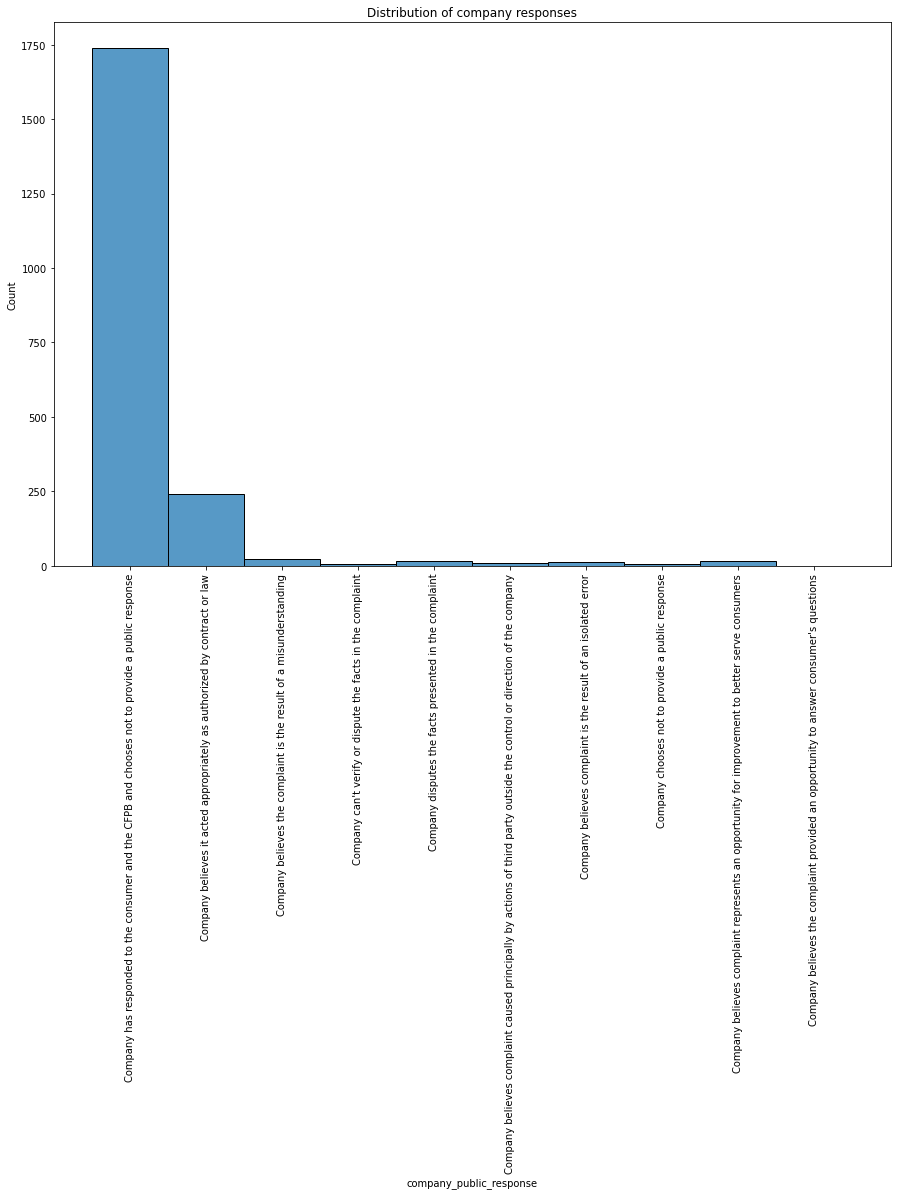

In [21]:
plt.figure(figsize=(15, 10))
sns.histplot(x='company_public_response', data=df)
plt.xticks(rotation=90)
plt.title('Distribution of company responses')
plt.show()

In [22]:
df.rename(columns={'complaint_what_happened':'complaint'}, inplace=True)
df.head()

,company_response,complaint,company_public_response,actions
1,Closed with explanation,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,Dispute
5,Closed with explanation,Hello This complaint is against the three cred...,Company has responded to the consumer and the ...,Dispute
6,Closed with explanation,I am a victim of Identity Theft & currently ha...,Company has responded to the consumer and the ...,Dispute
7,Closed with explanation,I have a active XXXX XXXX credit card in good ...,Company has responded to the consumer and the ...,Dispute
9,Closed with non-monetary relief,Two accounts are still on my credit history af...,Company has responded to the consumer and the ...,Dispute


In [23]:
import nltk
nltk.download('wordnet')

def processRow(row):
    import re
    import nltk
    from textblob import TextBlob
#     from nltk.corpus import stopwords
#     from nltk.stem import PorterStemmer
#     from textblob import Word
#     from nltk.util import ngrams
    import re
    #from wordcloud import WordCloud, STOPWORDS
    from nltk.tokenize import word_tokenize
    tweet = row
    #Lower case
    tweet.lower()
    #Removes unicode strings like "\u002c" and "x96"
    tweet = re.sub(r'(\\u[0-9A-Fa-f]+)',r"", tweet)
    tweet = re.sub(r'[^\x00-\x7f]',r"",tweet)
    #convert any url to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert any @Username to "AT_USER"
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('[\n]+', ' ', tweet)
    #Remove not alphanumeric symbols white spaces
    tweet = re.sub(r'[^\w]', ' ', tweet)
    #Removes hastag in front of a word """
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove :( or :)
    tweet = tweet.replace(':)',"")
    tweet = tweet.replace(':(',"")
    #remove numbers
    tweet = "".join([i for i in tweet if not i.isdigit()])
    #remove multiple exclamation
    tweet = re.sub(r"(\!)\1+", ' ', tweet)
    #remove multiple question marks
    tweet = re.sub(r"(\?)\1+", ' ', tweet)
    #remove multistop
    tweet = re.sub(r"(\.)\1+", ' ', tweet)
    #lemma
    from textblob import Word
    tweet =" ".join([Word(word).lemmatize() for word in tweet.split()])
    #stemmer
    #st = PorterStemmer()
    #tweet=" ".join([st.stem(word) for word in tweet.split()])
    #Removes emoticons from text
    tweet = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', "", tweet)
    #trim
    tweet = tweet.strip('\'"')
    row = tweet
    return row

df['complaint'] = df['complaint'].apply(lambda x: processRow(x))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nakshathru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


VALUE OF S is I contacted Ally on Friday XX/XX/XXXX after falling behind on payments due to being out of work for a short period of time due to an illness. I chated with a representative after logging into my account regarding my opitions to ensure I protect my credit and bring my account current. She advised me that before an extenstion could be done, I had to make a payment in the amount of {$270.00}. I reviewed my finances, as I am playing catch up on all my bills and made this payment on Monday XX/XX/XXXX. This rep advised me, once this payment posts to my account to contact Ally back for an extention or to have a payment deffered to the end of my loan. With this in mind, I contacted Ally again today and chatted with XXXX. I explained all of the above and the information I was provided when I chatted with the rep last week. She asked several questions and advised me that a one or two month extension/deffered payment could be done however partial payment is needed! WHAT? She advised

In [44]:
# X=enc.fit_transform(selected_df[['issue','sub_issue','consumer_disputed','complaint_what_happened','product']]).toarray()     
# y=enc.fit_transform(selected_df[['company_response']]).toarray()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


X_train, X_test, y_train, y_test = train_test_split(df['complaint'], df['actions'],random_state=0,test_size=0.3)

In [45]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [46]:
tfidf = TfidfVectorizer()
tfidf.fit(df['complaint'])
X_train_t = tfidf.transform(X_train)
X_test_t = tfidf.transform(X_test)

In [50]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

Creating classifier

In [51]:
clf = RandomForestClassifier(n_estimators = 100)  

training

In [53]:
clf.fit(X_train_t, y_train)

RandomForestClassifier()

predicting accuracy

In [55]:
y_pred = clf.predict(X_test_t)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9758064516129032


visualization

In [56]:
print(metrics.classification_report(y_test, clf.predict(X_test_t), target_names=df['actions'].unique()))

                  precision    recall  f1-score   support

         Dispute       0.00      0.00      0.00        13
          Agrees       0.98      1.00      0.99       605
Less informative       0.00      0.00      0.00         2

        accuracy                           0.98       620
       macro avg       0.33      0.33      0.33       620
    weighted avg       0.95      0.98      0.96       620



/Users/nakshathru/Documents/train_ML/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nakshathru/Documents/train_ML/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nakshathru/Documents/train_ML/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [57]:
matr = confusion_matrix(y_test, clf.predict(X_test_t))

In [60]:
# Predicitng in real time
sentence = ["This company refuses to provide me verification andvalidation of debt"+ "per my right under the FDCPA.I do not believe this debt is mine."]
feature_sent = tfidf.transform(sentence)
pred = clf.predict(feature_sent)
print(pred)

[1]


In [61]:
print(sentence)
print("This has been predicted as:",pred[0])

['This company refuses to provide me verification andvalidation of debtper my right under the FDCPA.I do not believe this debt is mine.']
This has been predicted as: 1
